# Self-Driving Car Engineer Nanodegree


## Project: **Advanced lane finding** 


**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.




## First step: calibrate the camera using chessboard images. 

See also https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html
and https://github.com/jensakut/CarND-Camera-Calibration


* **Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.**


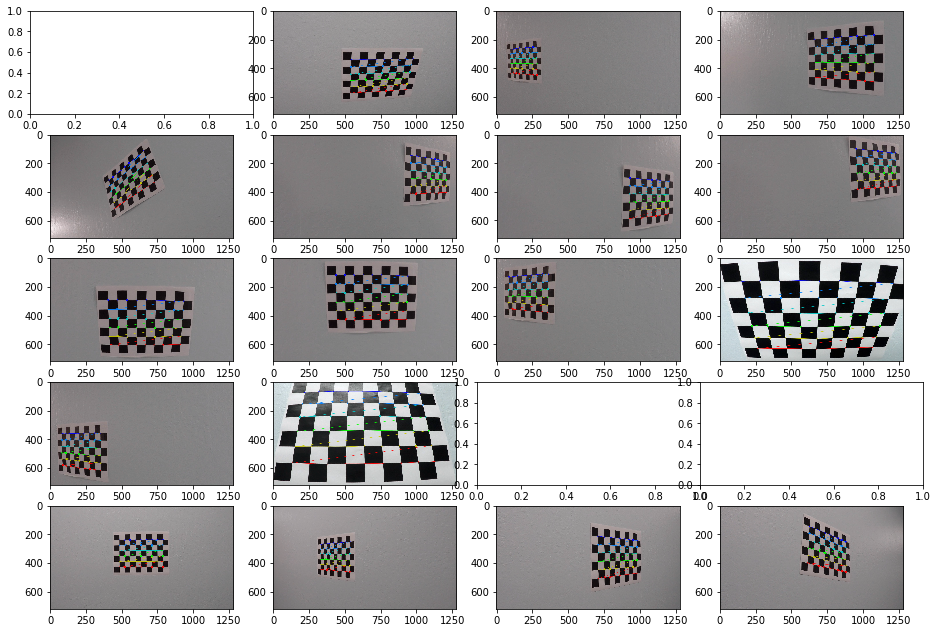

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
# depreciated?: 
#%matplotlib qt

# numbers of intersections in the chessboard
nx=9
ny=6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#create empty figures for plotting
fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points, plot image into the array
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #print(write_name)
        cv2.waitKey(500)
        
        #plot the image in the figure array
        axs[idx].imshow(img)

fig.savefig("output_images/step1_find_chessboard_corners.jpg")

cv2.destroyAllWindows()


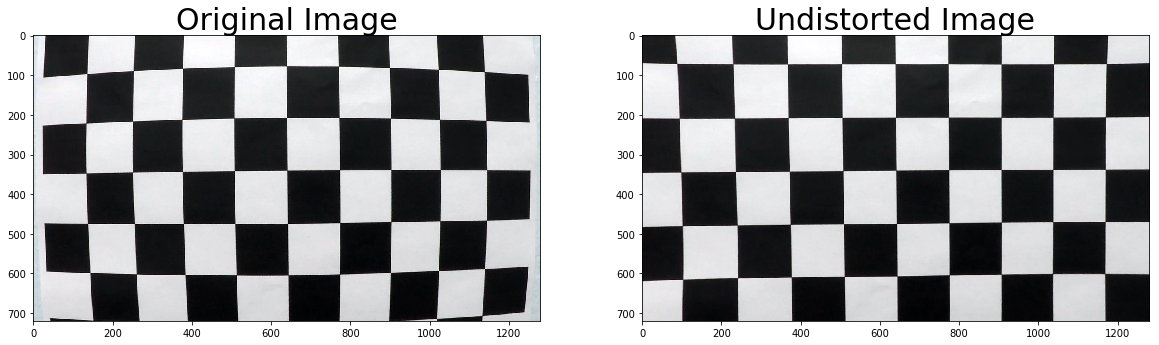

In [2]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/step1_test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/cal_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig("output_images/01_original_and_undistored.png")

## second step: image pipeline


* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* **Apply a distortion correction to raw images.**
* **Use color transforms, gradients, etc., to create a thresholded binary image.**

### image pipeline

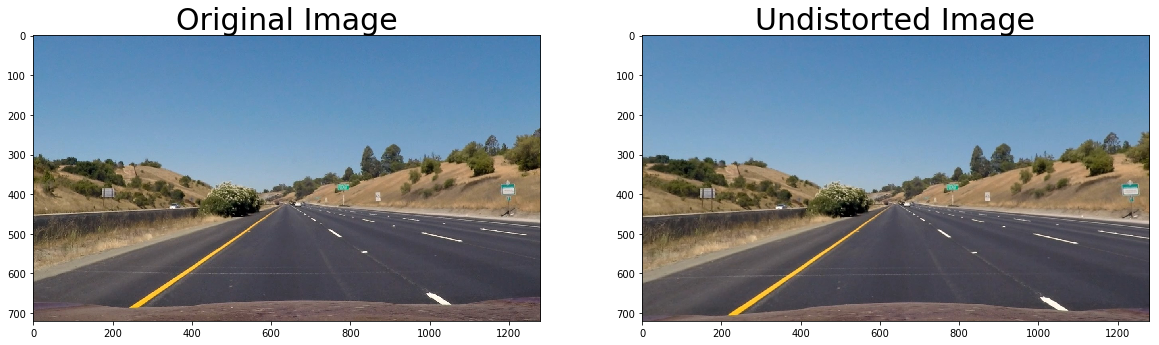

In [3]:
# read all images in folder test_images and save into list test_images
test_images_fname = glob.glob('test_images/*.jpg')
test_images=[]
for fname in test_images_fname:
    img = cv2.imread(fname)
    test_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

example_original =test_images[0]
example_undistorted = cv2.undistort(example_original, mtx, dist, None, mtx)


# Visualize undistortion on an example picture
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(example_original)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(example_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig("output_images/02_example_original_and_undistored.png")

In [4]:
def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Define a function that thresholds the S-channel of HLS
def hlS(img, show=False):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    saturation = hls[:,:,2];
    if show:
        plt.figure()
        plt.title('saturation')
        plt.imshow(saturation, 'gray')
    return saturation

# Define a function that thresholds the S-channel of HLS
def s_threshold(img, thresh=(0, 255), show=False):
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hlS = img_HLS[:,:,2];
    binary_output = np.zeros_like(hlS)
    binary_output[(hlS > thresh[0]) & (hlS <= thresh[1])] = 1
    if show:
        plt.figure()
        plt.title('saturation treshold')
        plt.imshow(binary_output, 'gray')
    return binary_output


def LUV_threshold(img, thresh=(0, 255), show=False):
    img_LUV=cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    Luv = img_LUV[:,:,0]
    binary_output = np.zeros_like(Luv)
    binary_output[(Luv > thresh[0]) & (Luv <= thresh[1])] = 1
    if show:
        plt.figure()
        plt.title('Luv treshold')
        plt.imshow(binary_output, 'gray')
    return binary_output

def LAB_threshold(img, thresh=(0, 255), show=False):
    img_LAB=cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    laB = img_LAB[:,:,2]
    binary_output = np.zeros_like(laB)
    binary_output[(laB > thresh[0]) & (laB <= thresh[1])] = 1
    if show:
        plt.figure()
        plt.title('laB treshold')
        plt.imshow(binary_output, 'gray')
    return binary_output


def sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(20, 100), show=False):
    # Calculate directional gradient
    # Apply threshold
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    else:
        print('damn')
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    #plt.imshow(scaled_sobel, 'gray')
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    if show:
        plt.figure()
        plt.title('sobel-treshold')
        plt.imshow(grad_binary, 'gray')
    # 6) Return this mask as your binary_output image
    return grad_binary

def binarize(image, LUV_t=[200,255], LAB_t=[180,255], show=False, singlechannel=False):
#depreciated: def binarize(image, sobel_kernel, sobel_t=[50,100], s_t=[170,255], LUV_t=[200,255], LAB_t=[180,255], show=False, singlechannel=False):

    #correct camera distortion
    undistorted=undist(image) 
    #grayscale
    gray= cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    LUV_binary = LUV_threshold(undistorted, LUV_t, show)
    LAB_binary = LAB_threshold(undistorted, LAB_t, show)
    #dummy binary as a third channel
    binary= np.zeros_like(image[:,:,0])

    if show:
        plt.figure()
        plt.imshow(np.dstack((LUV_binary, LAB_binary, binary)) * 255)
        plt.title('LUV_treshold, LAB_threshold, saturation_binary')

    if singlechannel:
        binary[ LUV_binary + LAB_binary > 0 ] = 1  
        #binary[(sobel_combined == 1) + (saturation_binary == 1) + LUV_binary + LAB_binary > 1 ] = 1  
        return binary
    else:
        color_binary = np.dstack((gray, LUV_binary, LAB_binary )) * 255
        return color_binary
    

### Tuning the pipeline

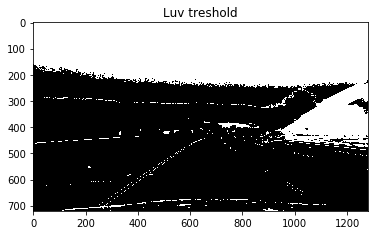

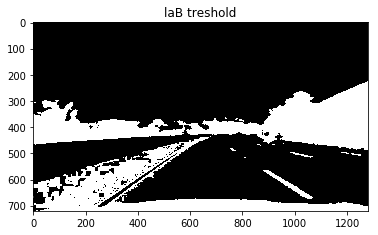

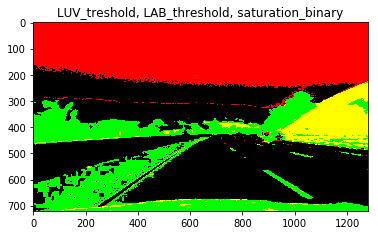

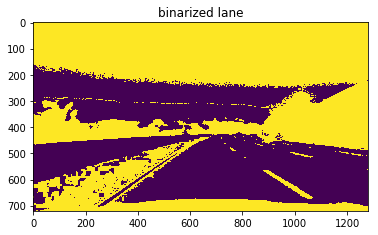

In [5]:
# http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# programm a slider to comfortably display all test pictures and the 
def slider(pictureid, LUVmin, LUVmax, LABmin, LABmax): 
# Step through the test images and print undistorted
    #for idx, fname in enumerate(test_images[0:4]):
        image = test_images[pictureid]
        ## gradients
        binarized_lane = binarize(image,[LUVmin,LUVmax],[LABmin,LABmax], True, True)
        plt.figure()
        plt.title('binarized lane')
        plt.imshow(binarized_lane)
        #axs[idx].imshow(lane_lines)
        #axs[idx].axis('off')
# depreciated: interact(slider, pictureid = (0,len(test_images)-1), sobel_kernel=(3,30,2),sobeltmin=(0,100), sobeltmax=(0,200), stmin=(150,255), stmax=(254,255), LUVmin=(0,255), LUVmax=(100,255), LABmin=(0,255), LABmax=(100,255));
interact(slider, pictureid = (0,len(test_images)-1), LUVmin=(0,255), LUVmax=(100,255), LABmin=(0,255), LABmax=(100,255));

# good values seem to be:
LUVmin = 210
LUVmax = 255
LABmin = 150
LABmax = 255

### Test the pipeline settings on example images

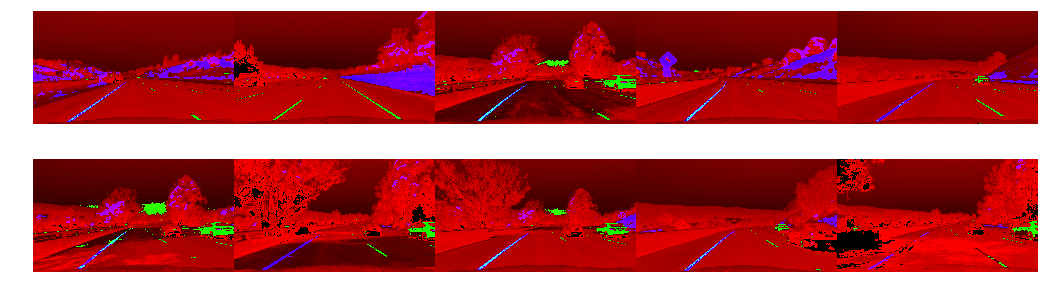

In [6]:

#create empty figures for plotting
fig15, axs = plt.subplots(2,5, figsize=(18, 5))
fig15.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the test images and print 
for idx, fname in enumerate(test_images):
    image = test_images[idx]
    #for plotting purposes produce a gray and distorted picture
    binarized_lane = binarize(image, [LUVmin, LUVmax],[LABmin, LABmax], False, False)
    axs[idx].imshow(binarized_lane)
    axs[idx].axis('off')
fig15.savefig("output_images/step2_2_binarized_images_LUV_LAB.jpg")


## 3. Bird's eye view 

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* ** Apply a perspective transform to rectify binary image ("birds-eye view"). **


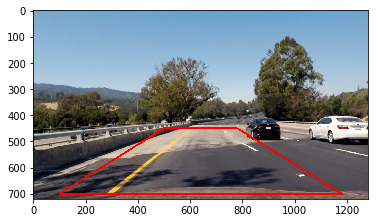

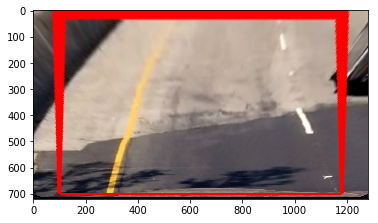

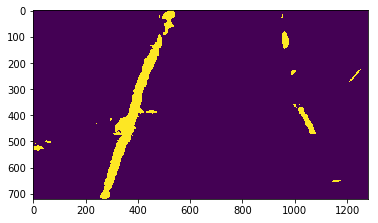

In [10]:

# ignoring slopes, a static transformation serves the purpose for the time being
# using either sensors or image analysis to determine the slope and changing the 
# y coordinate of the horizon accordingly would be interesting
undst=undist(test_images[5])
copy=undst.copy()

#plt.imshow(undst)
figsize=(18, 5)
left1=(100,700)  #190, 720
left2=(500,450) #further away
right1=(1180,700)
right2=(780,450) #further away
src = np.float32([left1,left2,right1,right2])

offset=400 #the offset for the spread of the inner points

dleft1=left1
dleft2=(left2[0]-offset,0)
dright1=right1
dright2=(right2[0]+offset,0)

dst = np.float32([dleft1,dleft2,dright1,dright2])

color = [255,0,0]
w = 2
#cv2.line(copy, src[0],src[1], color)
cv2.line(copy,left1,left2,(255,0,0),5)
cv2.line(copy,left2,right2,(255,0,0),5)
cv2.line(copy,right2,right1,(255,0,0),5)
cv2.line(copy,right1,left1,(255,0,0),5)

plt.figure()
plt.imshow(copy)

M = cv2.getPerspectiveTransform(src, dst)
MT = cv2.getPerspectiveTransform(dst, src)

def birds_eye(image, forward = True):
        img_size = (image.shape[1], image.shape[0])
        if forward:
            return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        else: 
            return cv2.warpPerspective(image, MT, img_size, flags=cv2.INTER_LINEAR)
plt.figure()
image_bird= birds_eye(copy)
plt.imshow(image_bird)
plt.figure()
plt.imshow(binarize(birds_eye(undst), [LUVmin,LUVmax],[LABmin,LABmax], False, True))


# video pipeline


In [16]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension



class pipeline():
    def __init__(self):
        self.right_average_fit=[]
        self.left_average_fit=[]
        self.left_detected = False
        self.right_detected = False
        self.left_best_fit = []
        self.right_best_fit = []
        self.left_allx=[]
        self.right_allx=[]
        self.left_ally=[]
        self.right_ally=[]
        self.left_foundpoints=[]
        self.right_foundpoints=[]
        self.curverad = [] #totally straight lane, easy to see in bugsearch
        self.dx = []
        
    def birds_eye(self, image, forward = True):
        img_size = (image.shape[1], image.shape[0])
        if forward:
            return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        else: 
            return cv2.warpPerspective(image, MT, img_size, flags=cv2.INTER_LINEAR)
    
    def append_and_pop_points(self,leftx,rightx,lefty,righty,filterlength=6,nr_points=10):

        self.left_allx.extend(leftx)
        self.left_ally.extend(lefty)
        self.right_allx.extend(rightx)
        self.right_ally.extend(righty)
        
        self.left_foundpoints.append(len(leftx))
        self.right_foundpoints.append(len(rightx))
        
        if len(self.left_foundpoints)>=filterlength:
            popping=self.left_foundpoints[-filterlength]-1
            #print(popping)
            self.left_allx = self.left_allx[popping:]
            self.left_ally = self.left_ally[popping:]
        if len(self.right_foundpoints)>=filterlength:
            popping=self.right_foundpoints[-filterlength]-1
            #print(popping)
            self.right_allx = self.right_allx[popping:]
            self.right_ally = self.right_ally[popping:]
                
        
        if len(leftx)>nr_points: 
            self.left_detected=True
        else:
            self.left_detected=False
        
        if len(rightx)>nr_points:
            self.right_detected=True
        else:
            self.right_detected=False
        self.left_detected

    def find_lanes(self, binary_warped, show=False):

        # udacity class inspired
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        midpointx = np.int(binary_warped.shape[0]/2)
        histogram = np.sum(binary_warped[midpointx:,:], axis=0)
        if False:
            plt.figure()
            plt.plot(histogram)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*127
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpointy = np.int(binary_warped.shape[1]/2)
        leftx_base = np.argmax(histogram[:midpointy])
        rightx_base = np.argmax(histogram[midpointy:]) + midpointy
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
                
        if show: 
                plt.figure()
                # Generate x and y values for plotting
                ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
                left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
                right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
                out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
                out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
                plt.imshow(out_img)
                plt.plot(left_fitx, ploty, color='yellow')
                plt.plot(right_fitx, ploty, color='yellow')
                plt.xlim(0, 1280)
                plt.ylim(720, 0)
        
        return leftx, lefty, rightx, righty


    def update_lanes(self, binary_warped, left_fit, right_fit, show=False):

        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )



        if show: 
            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.figure()
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            window_img = np.zeros_like(out_img)
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
        
        return leftx, lefty, rightx, righty
    
    def drawLine(self, image, left_fit, right_fit, curver, dx):
    
        yMax = image.shape[0]
        ploty = np.linspace(0, yMax-1, yMax)
        color_warp = np.zeros_like(image).astype(np.uint8)
        
        left_fitx = np.polyval(left_fit,ploty)
        right_fitx = np.polyval(right_fit,ploty)
        
        # convert into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
    
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        if True:
            # Create an image to draw on and an image to show the selection window
            points = np.zeros_like(image)
            # Color in left and right line pixels
            points[self.left_ally, self.left_allx] = [255, 0, 0]
            points[self.right_ally, self.right_allx] = [0, 0, 255]
            points_uw=birds_eye(points, forward=False)
        # inverse back
        newwarp = birds_eye(color_warp, forward = False) 
        output = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        output2 = cv2.addWeighted(output, 1, points_uw, 1, 0)
        text="The curvature radius is %d m. The car is %.2f m off center" % (curver, dx)
        cv2.putText(output2, text, (50, 50), 0, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
        return output2#cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    
    def mean_lanes(self):
        # returns lane-polynom based on the last lane points saved in the class
        
        if len(self.left_ally)>5:
            left = np.polyfit(self.left_ally, self.left_allx, 2)
        else: 
            #just keep the last approximation if there aren't any new points. 
            #if this happens often, there needs to be further validation
            left=self.left_best_fit
        if len(self.right_ally)>5:
            right = np.polyfit(self.right_ally, self.right_allx, 2)
        else:
            right=self.right_best_fit
        #calculate offset from center:
        lane_midpoint = (np.polyval(left, 720)+np.polyval(right,720))*0.5
        vehicle_position  = image.shape[1]*0.5
        dx=(vehicle_position-lane_midpoint)*xm_per_pix # positive for offsets to the right
        return left, right, dx
    
    def curve_radius(self): 
        #takes the points from the previous frames saved in class and returns an weighted radius of both right and left 
        #lanes
        if len(self.left_ally) > 0 and len(self.right_ally)>0:
            # Define conversions in x and y from pixels space to meters
            all_left_y=np.array(self.left_ally)
            all_left_x=np.array(self.left_allx)
            all_right_y=np.array(self.right_ally)
            all_right_x=np.array(self.right_allx)
            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(all_left_y*ym_per_pix, all_left_x*xm_per_pix, 2)
            right_fit_cr = np.polyfit(all_right_y*ym_per_pix, all_right_x*xm_per_pix, 2)
            # Calculate the new radii of curvature at the mean of the right lane points
            # used in evaluation. The curve should be stable in the middle of the points, 
            # where the polynom does not extrapolate very well to it's borders
            y_evalr = np.mean(all_right_y)
            y_evall = np.mean(all_left_y)
            left_curverad = ((1 + (2*left_fit_cr[0]*y_evall*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_evalr*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            # Now our radius of curvature is in meters
            #print(left_curverad, 'm', right_curverad, 'm')
            # the inner curve provides the radius, because the outer curve optically doesn't bend to well.. 
            self.curverad.append(min(left_curverad, right_curverad))
            if len(self.curverad)>10:
                del self.curverad[0]
        return np.mean(self.curverad)


    def process_image(self, frame, video=True, show=False):
        #the main routine to be accessed from outside
        # takes frame, undistorts, searches for points, calculates a lane based on the last frames
        # and a curve radius
        # if used for single picture, it is beneficial to respawn the class to clear the cached lanes
        frame_undist = undist(frame)
        birdsimg=birds_eye(frame_undist)
        binary_warped= binarize(birdsimg, [LUVmin, LUVmax],[LABmin, LABmax], False, True)
    
        if self.right_detected == False | self.left_detected ==False:
            leftx, lefty, rightx, righty = self.find_lanes(binary_warped, show)
        else:
            leftx, lefty, rightx, righty = self.update_lanes(binary_warped, self.left_best_fit, self.right_best_fit)
        
        self.append_and_pop_points(leftx,rightx,lefty,righty,10,25)
        self.left_best_fit, self.right_best_fit, self.dx = self.mean_lanes()
        curverad =self.curve_radius()
        return self.drawLine(frame_undist, self.left_best_fit, self.right_best_fit, curverad, self.dx)
        
#initialize pipeline
x=pipeline()


<function __main__.slideshow>

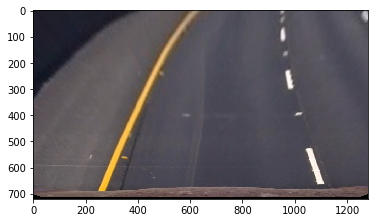

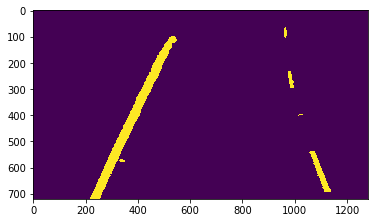

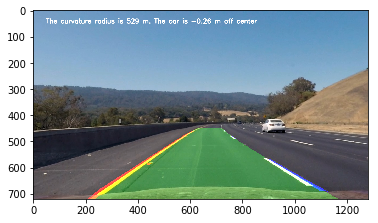

In [17]:
def slideshow(pictureid):
    #reinitialize pipeline in order to clear cached previous lines of the video function
    x=pipeline()
    image=test_images[pictureid]
    undst=undist(image)
    plt.imshow(x.birds_eye(image))
    plt.figure()
    plt.imshow(binarize(birds_eye(undst),[LUVmin,LUVmax],[LABmin,LABmax], False, True))
    plt.figure()
    plt.imshow(x.process_image(image, False))
interact(slideshow, pictureid = (0,len(test_images)-1))

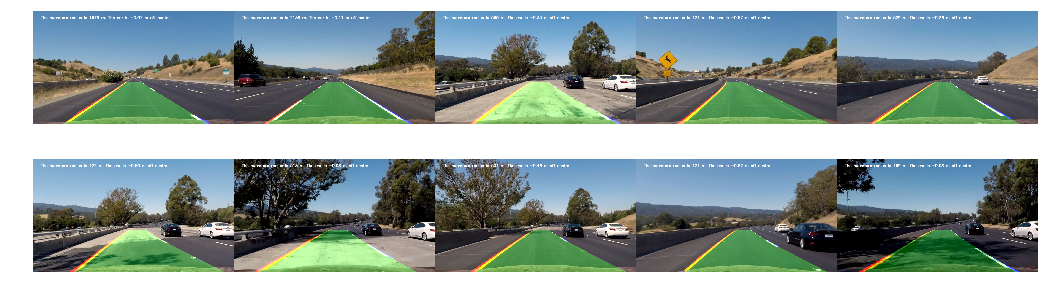

In [18]:
fig15, axs = plt.subplots(2,5, figsize=(18, 5))
fig15.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the test images and print 
for idx, fname in enumerate(test_images):
    #reinitialize pipeline in order to clear cached previous lines of the video function
    x=pipeline()
    image = test_images[idx]
    #for plotting purposes produce a gray and distorted picture
    binarized_lane = x.process_image(test_images[idx], False)
    axs[idx].imshow(binarized_lane)
    axs[idx].axis('off')
fig15.savefig("output_images/pipeline_results.jpg")


In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#the video gets it's own pipeline just to be sure there's nothing cached in there. 
abc=pipeline()

output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")#.subclip(20,35)
video_clip = clip1.fl_image(abc.process_image) 
%time video_clip.write_videofile(output, audio=False)
video_clip.reader.close()
video_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:55<00:00,  2.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 6min 56s


In [20]:
challenge=pipeline()
output = 'output_videos/challenge_video.mp4'
clip1 = VideoFileClip("videos/challenge_video.mp4")#.subclip(5,10)
video_clip = clip1.fl_image(challenge.process_image) 
%time video_clip.write_videofile(output, audio=False)
video_clip.reader.close()
video_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:29<00:00,  5.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 1min 29s


##### 